In [24]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# Regression Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
# subsample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import BorderlineSMOTE
# clustering
from sklearn.cluster import AgglomerativeClustering 
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
# Classification metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import cohen_kappa_score

# Ignore ConvergenceWarning messages
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
train = pd.read_csv('train.csv')
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,NAME_YIELD_GROUP,NFLAG_INSURED_ON_APPROVAL,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,Diff_applied_apprved,Days_consumerloans,AMT_credit_consumerloans,Days_cashloans,AMT_credit_cashloans,Days_revolvingloans,AMT_credit_revolvingloans,MONTHS_BALANCE0_x,balance_pct_change0,MONTHS_BALANCE1_x,balance_pct_change1,MONTHS_BALANCE2_x,balance_pct_change2,MONTHS_BALANCE3_x,balance_pct_change3,has_cc_now,balance_now,times_bal80,DAYS_INSTALMENT_first,insta_debt_sum,insta_debt_mean,insta_debt_first,insta_delinquency_sum,insta_delinquency_first,MONTHS_BALANCE0_y,SK_DPD0,SK_DPD_DEF0,MONTHS_BALANCE1_y,SK_DPD1,SK_DPD_DEF1,MONTHS_BALANCE2_y,SK_DPD2,SK_DPD_DEF2,MONTHS_BALANCE3_y,SK_DPD3,SK_DPD_DEF3
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,0.0,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,low_normal,0.0,1.0,1.0,0.0,-606.0,179055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-25.0,0.000,0.000000,0.0,0.0,0.0,-13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,0.0,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,low_normal,1.0,1.0,1.0,-135882.0,-828.0,348637.5,-746.0,1035882.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-536.0,0.000,0.000000,0.0,0.0,0.0,-23.0,0.0,0.0,-66.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,middle,0.0,1.0,1.0,4176.0,-815.0,20106.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-724.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,0.0,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,XNA,0.0,1.0,1.0,0.0,-311.0,267930.0,-181.0,675000.0,-181.0,270000.0,-1.0,0.0,-2.0,0.0,-5.0,0.0,0.0,0.0,1.0,0.0,0.0,-11.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,0.0,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,middle,1.0,1.0,1.0,-26788.5,-1768.0,30663.0,-374.0,274288.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-14.0,29857.365,452.384318,0.0,16.0,0.0,-3.0,0.0,0.0,-9.0,0.0,0.0,-10.0,0.0,0.0,-35.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,22

In [27]:
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            # print("******************************")
            # print("Column: ",col)
            # print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            # print("dtype after: ",props[col].dtype)
            # print("******************************")
    
    # Print final result
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props    

In [28]:
# train = reduce_mem_usage(train)
train = train.sample(frac=1)
train = train[:40000]

In [29]:
corr = train.corr()
corr

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,AMT_DOWN_PAYMENT,NFLAG_INSURED_ON_APPROVAL,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,Diff_applied_apprved,Days_consumerloans,AMT_credit_consumerloans,Days_cashloans,AMT_credit_cashloans,Days_revolvingloans,AMT_credit_revolvingloans,MONTHS_BALANCE0_x,balance_pct_change0,MONTHS_BALANCE1_x,balance_pct_change1,MONTHS_BALANCE2_x,balance_pct_change2,MONTHS_BALANCE3_x,balance_pct_change3,has_cc_now,balance_now,times_bal80,DAYS_INSTALMENT_first,insta_debt_sum,insta_debt_mean,insta_debt_first,insta_delinquency_sum,insta_delinquency_first,MONTHS_BALANCE0_y,SK_DPD0,SK_DPD_DEF0,MONTHS_BALANCE1_y,SK_DPD1,SK_DPD_DEF1,MONTHS_BALANCE2_y,SK_DPD2,SK_DPD_DEF2,MONTHS_BALANCE3_y,SK_DPD3,SK_DPD_DEF3
SK_ID_CURR,1.000000,0.001264,0.004226,-0.004049,-0.013828,-0.010974,-0.013775,0.000246,0.001619,0.002871,-0.002358,-0.005594,0.002765,NaN,-0.002937,0.006010,0.001866,-0.000644,-0.002711,0.001226,0.004703,0.002814,-0.001591,-0.001402,-0.004585,-0.002667,0.000954,-0.005279,-0.005798,-0.001610,0.007543,0.006239,0.004874,0.008880,0.004622,0.008185,-0.005124,0.005918,0.000876,0.001889,...,0.004152,0.004028,0.000799,0.004545,-0.005263,-0.000484,0.000672,0.003713,0.001044,-0.005500,0.001115,0.004163,0.001825,0.002469,0.006197,-0.002946,-0.000164,0.000028,0.007142,-0.000300,0.005739,0.003060,0.007420,-0.001101,-0.001879,0.003028,0.001654,-0.001427,-0.003329,0.002023,0.000676,0.002170,0.001551,0.007762,-0.002769,0.001270,-0.000394,0.003726,0.001494,0.001596
TARGET,0.001264,1.000000,0.013308,-0.016510,-0.026964,-0.011706,-0.035941,-0.038703,0.073623,-0.043808,0.039927,0.054718,0.003171,NaN,0.044836,0.022678,-0.000491,-0.025053,-0.006432,0.006228,0.060554,0.063414,-0.022391,0.004048,0.002511,-0.000614,0.038182,0.046881,0.032231,-0.063351,-0.159318,-0.121773,-0.039385,-0.033668,-0.042177,-0.030027,-0.020976,-0.033555,-0.040382,-0.050257,...,-0.022068,0.007969,0.018781,0.020040,-0.004739,0.011172,-0.029206,0.004973,-0.011356,0.003151,0.006502,-0.006009,0.013748,-0.006454,0.004715,-0.001925,0.015342,0.005466,0.001787,0.014755,0.021230,0.010134,0.001254,0.024365,0.025567,0.003885,0.034842,0.046808,0.013153,0.000480,0.016199,0.019336,-0.000581,0.021962,0.024549,0.002734,0.025743,0.022940,-0.000053,0.015267
CNT_CHILDREN,0.004226,0.013308,1.000000,0.027101,0.006979,0.023501,0.003343,-0.027285,0.327127,-0.235037,0.183494,-0.023900,0.065072,NaN,0.236033,0.052531,-0.002870,-0.031004,0.019109,0.878751,0.028542,0.027913,-0.003377,-0.011700,0.009675,0.015855,0.021718,0.074964,0.072560,0.050878,-0.014349,-0.014657,-0.029357,-0.025020,-0.034806,-0.019360,-0.017429,-0.016471,-0.029995,-0.031837,...,0.013686,-0.041128,0.019248,0.026798,0.028854,0.033320,0.006860,0.046560,-0.043153,0.011215,-0.005474,0.004680,0.000282,0.009890,-0.001991,0.013785,-0.006279,0.018875,-0.003689,-0.003693,-0.002416,-0.014572,-0.014863,0.005127,0.005832,0.005592,-0.011496,0.002800,-0.036961,0.003477,0.008900,-0.032022,0.001573,0.011196,-0.025206,0.000805,-0.001679,-0.008604,-0.000724,-0.002168
AMT_INCOME_TOTAL,-0.004049,-0.016510,0.027101,1.000000,0.271229,0.345003,0.277600,0.124986,0.038865,-0.106495,0.047119,0.015344,0.041005,NaN,0.106034,-0.028139,-0.011763,-0.003740,0.066750,0.031093,-0.144859,-0.156573,0.069775,0.049664,0.099973,0.091740,0.006712,0.011701,0.013517,0.066587,0.112159,0.006828,0.089194,0.063087,0.076333,0.0643

In [30]:
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]
to_drop

['AMT_GOODS_PRICE',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'STATUS_0']

In [31]:
train = train.drop(to_drop, axis=1)

In [32]:
train['OCCUPATION_TYPE'].value_counts()/len(train) 
train['OCCUPATION_TYPE'].unique()
train['OCCUPATION_TYPE'].replace([ 'Cleaning staff', 'Cooking staff', 'Accountants', 'Medicine staff'
        'Private service staff', 'Security staff','Waiters/barmen staff',
        'Low-skill Laborers', 'Realty agents', 'Secretaries', 'IT staff', 'HR staff'], 'Others', inplace= True)
train['ORGANIZATION_TYPE'].value_counts()/len(train) 
train['ORGANIZATION_TYPE'].replace(['School', 'Religion',
       'Other','Electricity', 'Medicine',
       'Transport: type 2',
       'Construction', 'Housing', 'Kindergarten', 'Trade: type 7',
       'Industry: type 11', 'Military', 'Services', 'Security Ministries',
       'Transport: type 4', 'Industry: type 1', 'Emergency', 'Security',
       'Trade: type 2', 'University', 'Transport: type 3', 'Police',
       'Business Entity Type 1', 'Postal', 'Industry: type 4',
       'Agriculture', 'Restaurant', 'Culture', 'Hotel',
       'Industry: type 7', 'Trade: type 3', 'Industry: type 3', 'Bank',
       'Industry: type 9', 'Insurance', 'Trade: type 6',
       'Industry: type 2', 'Transport: type 1', 'Industry: type 12',
       'Mobile', 'Trade: type 1', 'Industry: type 5', 'Industry: type 10',
       'Legal Services', 'Advertising', 'Trade: type 5', 'Cleaning',
       'Industry: type 13', 'Trade: type 4', 'Telecom',
       'Industry: type 8', 'Realtor', 'Industry: type 6'], 'Others', inplace = True)
train.describe() #outlier: max(days_Employed)
outlier = train[train['DAYS_EMPLOYED'] == 365243]
outlier['TARGET'].value_counts()/len(outlier)
train['DAYS_EMPLOYED'].describe()
train['TARGET'].value_counts()/len(train) # Outlier had lower rate of default (target = 1)

0    0.918675
1    0.081325
Name: TARGET, dtype: float64

In [33]:
# train['Days_employed_outlier'] = train['DAYS_EMPLOYED'] == 365243
train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True) # replace outlier by 
train['DAYS_EMPLOYED'].fillna(np.mean(train['DAYS_EMPLOYED']), inplace= True) # fill na with by mean of the column

In [34]:
# Feature engineering
train['Credit_income_ratio'] = train['AMT_CREDIT']/train['AMT_INCOME_TOTAL']
train['Anuity_income_ratio'] = train['AMT_ANNUITY']/train['AMT_INCOME_TOTAL'] 
train['Credit_term'] = train['AMT_ANNUITY']/train['AMT_CREDIT'] #length of the payment in months since the annuity is the monthly amount due
train['Days_employed_age'] = train['DAYS_EMPLOYED']/train['DAYS_BIRTH']

In [35]:
corr = train.corr()['TARGET'].sort_values()
corr.head(10)

EXT_SOURCE_2                  -0.159318
EXT_SOURCE_3                  -0.121773
EXT_SOURCE_1                  -0.063351
Days_employed_age             -0.052021
FLOORSMAX_AVG                 -0.050257
ratio_approved                -0.043479
TOTALAREA_MODE                -0.042820
YEARS_BEGINEXPLUATATION_AVG   -0.042177
LIVINGAREA_AVG                -0.041096
ENTRANCES_AVG                 -0.040382
Name: TARGET, dtype: float64

In [36]:
corr.tail(10)

REG_CITY_NOT_WORK_CITY         0.046881
DAYS_ID_PUBLISH                0.054718
DAYS_LAST_PHONE_CHANGE         0.055676
REGION_RATING_CLIENT           0.060554
REGION_RATING_CLIENT_W_CITY    0.063414
DAYS_EMPLOYED                  0.066634
DAYS_BIRTH                     0.073623
ratio_refused                  0.080526
TARGET                         1.000000
FLAG_MOBIL                          NaN
Name: TARGET, dtype: float64

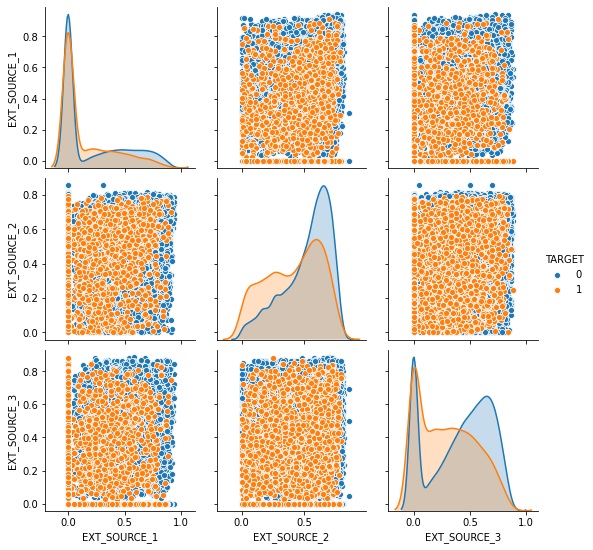

In [37]:
cols = ['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
sns.pairplot(train[cols][:30000], height = 2.5, hue='TARGET')
plt.show()

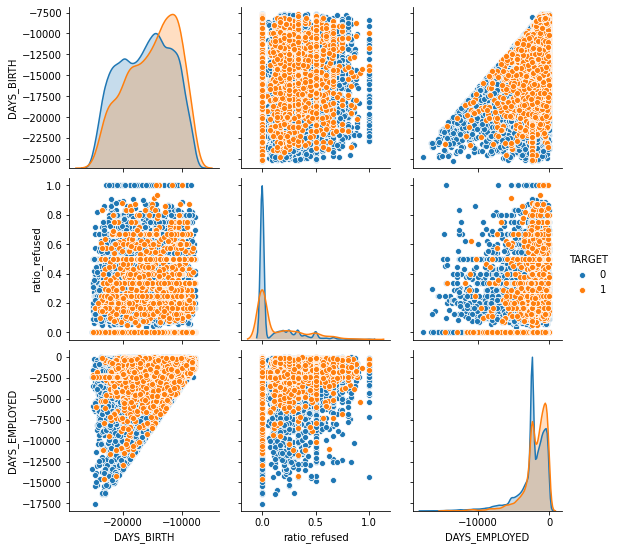

In [38]:
cols = ['TARGET','DAYS_BIRTH', 'ratio_refused', 'DAYS_EMPLOYED']
sns.pairplot(train[cols][:30000], height = 2.5, hue= 'TARGET')
plt.show()

In [39]:
# # Polynomial Features
# from sklearn.preprocessing import PolynomialFeatures
# poly_transformer = PolynomialFeatures(degree = 3)
# pfeatures = train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'ratio_refused']] 
# poly_features = poly_transformer.fit_transform(pfeatures)
# names = poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'ratio_refused'])
# poly_features = pd.DataFrame(poly_features, columns = names)
# poly_features['SK_ID_CURR'] = train['SK_ID_CURR'].values
# train = train.merge(poly_features, on='SK_ID_CURR', how= 'left')
# train


In [40]:
train = pd.get_dummies(train, drop_first=True)

In [41]:
train['TARGET'].value_counts()/len(train)

0    0.918675
1    0.081325
Name: TARGET, dtype: float64

In [42]:
y = train['TARGET']
X = train.drop('TARGET', axis=1)

In [43]:
# sc = StandardScaler()
# X_pca = sc.fit_transform(X)
# pca = PCA(n_components = 175)
# X_pca = pca.fit_transform(X_pca)
# sum(pca.explained_variance_ratio_)

In [44]:
train.shape

(40000, 265)

In [57]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.1, random_state=1234)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
print(tf.__version__)

2.2.0


In [89]:
model = Sequential()
model.add(Dense(input_shape= (264,) , units= 150, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units= 75, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units= 25, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
model.compile(loss='BinaryCrossentropy',
              optimizer ='adam' ,
              metrics='AUC')

In [90]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 150)               39750     
_________________________________________________________________
dropout_24 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 75)                11325     
_________________________________________________________________
dropout_25 (Dropout)         (None, 75)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 25)                1900      
_________________________________________________________________
dropout_26 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)               

In [91]:
model.fit(X_train, y_train, batch_size=1024, epochs= 50 )

Epoch 1/50
36/36 [==============================] - 0s 5ms/step - loss: 0.3886 - auc: 0.5375
Epoch 2/50
36/36 [==============================] - 0s 5ms/step - loss: 0.2755 - auc: 0.6703
Epoch 3/50
36/36 [==============================] - 0s 5ms/step - loss: 0.2629 - auc: 0.7124
Epoch 4/50
36/36 [==============================] - 0s 5ms/step - loss: 0.2569 - auc: 0.7321
Epoch 5/50
36/36 [==============================] - 0s 5ms/step - loss: 0.2527 - auc: 0.7450
Epoch 6/50
36/36 [==============================] - 0s 6ms/step - loss: 0.2484 - auc: 0.7587
Epoch 7/50
36/36 [==============================] - 0s 5ms/step - loss: 0.2462 - auc: 0.7646
Epoch 8/50
36/36 [==============================] - 0s 5ms/step - loss: 0.2434 - auc: 0.7728
Epoch 9/50
36/36 [==============================] - 0s 6ms/step - loss: 0.2397 - auc: 0.7831
Epoch 10/50
36/36 [==============================] - 0s 5ms/step - loss: 0.2393 - auc: 0.7830
Epoch 11/50
36/36 [==============================] - 0s 6ms/step - lo

In [92]:
from sklearn.metrics import accuracy_score
pred = model.predict(X_test)
print('AUC', roc_auc_score(y_test, pred))
pred_class = model.predict(X_test)
# print( 'XGBoost accuracy:', accuracy_score(y_test, pred_class))

AUC 0.640526409286722


In [94]:
# Import confusion_matrix
from sklearn.metrics import confusion_matrix
# print( confusion_matrix(y_test, pred_class) )
# cm = confusion_matrix(y_test, pred_class)
pred_class_2 = (np.array(pred) > 0.1).astype(int)
print(confusion_matrix(y_test, pred_class_2))
cm = confusion_matrix(y_test, pred_class_2)
# True Positives (TP)
tp = cm[1][1]
# False Positives (FP)
fp = cm[0][1]
# True Negatives (TN)
tn = cm[0][0]
# False Negatives (FN)
fn = cm[1][0]
precision = tp / (tp + fp)
print( 'Precision:', precision )
recall = tp / (tp + fn)
print( 'Recall', recall )

[[3330  352]
 [ 240   78]]
Precision: 0.1813953488372093
Recall 0.24528301886792453


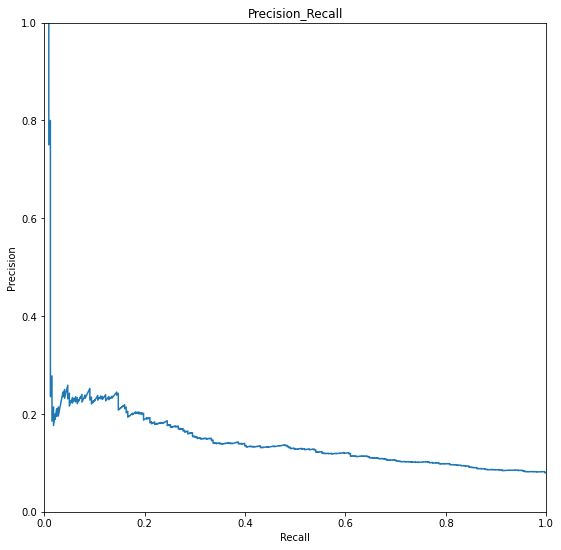

In [95]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, pred)
# pd.DataFrame({'precision': precision, 'recall' : recall})
# Initialize figure
fig = plt.figure(figsize=(9,9))
plt.title('Precision_Recall')

# Plot Precision-Recall curve
plt.plot(recall, precision)

# Axes limits and labels
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [96]:
# Calculate ROC curve from y and pred
fpr, tpr, thresholds = roc_curve(y_test, pred)
f1score = 2*(tpr+fpr)/(tpr*fpr)
precision = tpr / (tpr + fpr)
recall = tpr
pd.DataFrame({'Precision': precision, 'Recall' : tpr, 'F1SCORE': f1score, 'Thresholds' : thresholds})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


,Precision,Recall,F1SCORE,Thresholds
0,NaN,0.000000,NaN,2.000000e+00
1,1.000000,0.003145,inf,1.000000e+00
2,1.000000,0.009434,inf,9.989979e-01
3,0.972017,0.009434,7576.000000,9.866951e-01
4,0.978865,0.012579,7523.000000,9.862126e-01
...,...,...,...,...
552,0.509115,0.996855,4.087123,4.087138e-06
553,0.501258,0.996855,4.022739,2.973614e-09
554,0.502045,1.000000,4.016429,2.862988e-09
555,0.500272,1.000000,4.002175,5.096317e-28


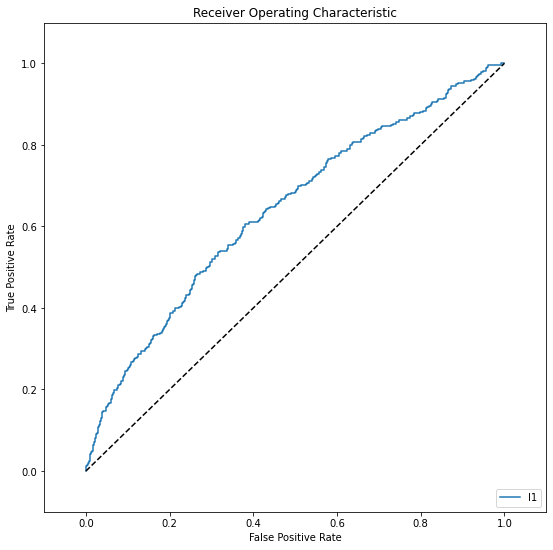

In [97]:
# Initialize figure
fig = plt.figure(figsize=(9,9))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [98]:
# AUROC
roc_auc_score(y_test, pred)

0.640526409286722

In [99]:
pred_class_v2 = (np.array(pred) > 0.2).astype(int)
cohen_kappa = cohen_kappa_score(y_test, pred_class_v2)
cohen_kappa

0.1228070175438597